# E-commerce Customer Segmentation using Machine Learning

## Project Description
This project focuses on analyzing e-commerce customer behavior using transactional data and segmenting customers into meaningful groups.
RFM (Recency, Frequency, Monetary) analysis and K-Means clustering are used to group customers based on purchasing patterns.

In [1]:
import pandas as pd

file_path = "/content/online_retail_II.xlsx"

df = pd.read_excel(file_path)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Dataset Description
The Online Retail II dataset contains real-world e-commerce transaction records including invoice number, product details, quantity, price, purchase date, customer ID, and country.
This dataset is suitable for customer segmentation as it provides complete transactional history required for RFM analysis.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## Data Preprocessing
Data preprocessing is required to clean the dataset before analysis.
This includes removing missing customer IDs and excluding returned transactions to ensure accurate results.

In [3]:
df = df.dropna(subset=['Customer ID'])

In [4]:
df = df[df['Quantity'] > 0]

## Total Purchase Value Calculation
The total monetary value of each transaction is calculated by multiplying quantity and price.
This value is used in the Monetary component of RFM analysis.

In [5]:
df['TotalAmount'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## RFM Analysis
RFM analysis evaluates customers based on three factors:
- Recency: How recently a customer made a purchase
- Frequency: How often a customer makes purchases
- Monetary: How much money a customer spends

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2010-12-10 20:01:00')

In [8]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2671.14
12351.0,11,21,300.93


## Data Normalization
RFM values have different scales.
StandardScaler is used to normalize the data so that each feature contributes equally to clustering.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled[:5]

array([[ 0.76064344, -0.30448567, -0.18789547],
       [-0.91062704, -0.11636378, -0.08123991],
       [-0.17815665, -0.36884315, -0.20480622],
       [-0.49796767,  0.03710407,  0.07000528],
       [-0.82809517, -0.36389258, -0.19596707]])

## Customer Segmentation using K-Means
K-Means is an unsupervised machine learning algorithm used to group similar customers.
In this project, customers are divided into three clusters based on RFM values.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,165,33,372.86,1
12347.0,3,71,1323.32,0
12348.0,74,20,222.16,0
12349.0,43,102,2671.14,0
12351.0,11,21,300.93,0


## Cluster Distribution
The number of customers in each cluster is analyzed to understand customer segmentation.

In [11]:
rfm['Cluster'].value_counts()

,count
Cluster,
0,3247
1,1055
2,12


## Visualization of Customer Segments
A scatter plot between Recency and Monetary value is used to visualize customer clusters.

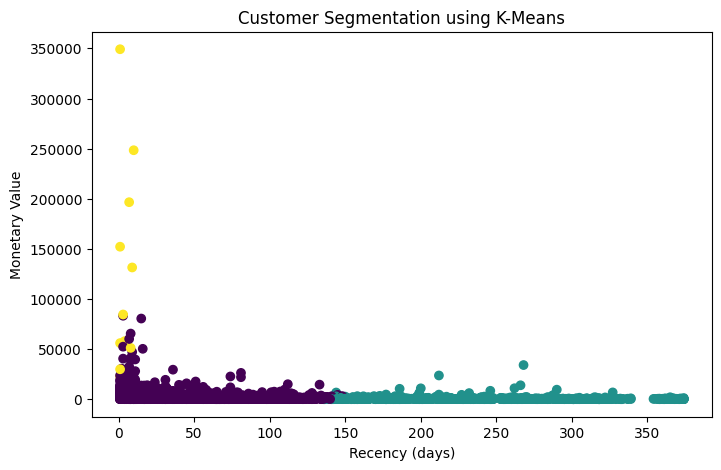

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(rfm['Recency'], rfm['Monetary'],
            c=rfm['Cluster'], cmap='viridis')
plt.xlabel("Recency (days)")
plt.ylabel("Monetary Value")
plt.title("Customer Segmentation using K-Means")
plt.show()

## Cluster Interpretation
The average RFM values of each cluster are analyzed to interpret customer behavior.

In [13]:
rfm.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,42.448722,106.585464,2089.118516
1,242.517536,29.806635,615.900667
2,4.000000,2513.833333,116571.687500


## Conclusion
This project successfully demonstrates e-commerce customer segmentation using RFM analysis and K-Means clustering.
The results help identify high-value, medium-value, and low-value customers, which can support targeted marketing and customer retention strategies.